In [1]:
%load_ext autoreload
%autoreload 2

# TODO: Think about plotting subset sizes against predicted probability? (confidence)

DATASET_NAME = "toxigen"
LABEL_SPACE = ["non-toxic", "toxic"]
MODEL_NAME = "deberta-large"
SEED = 42
POOLER = "mean_with_attention"
LAYER = 24

In [2]:
# load embeddings
from data.embeddings import load_saved_embeddings
import numpy as np
train_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="train",
    pooler=POOLER,
    layer=LAYER
)

eval_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="eval",
    pooler=POOLER,
    layer=LAYER
)

test_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="test",
    pooler=POOLER,
    layer=LAYER
)

train_eval_embeddings = np.vstack([train_embeddings, eval_embeddings])


# load classifier
from data.models import load_saved_wrapperbox_model
knn_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="KNN"
)

svm_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="SVM",
)

dt_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="DecisionTree",
)

lmeans_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="LMeans",
)

# load labels 
from data.datasets import load_dataset_from_hf, load_labels_at_split
import numpy as np
dataset = load_dataset_from_hf(dataset=DATASET_NAME)
train_labels = load_labels_at_split(dataset, "train")
eval_labels = load_labels_at_split(dataset, "eval")
train_eval_labels = np.concatenate([train_labels, eval_labels])
test_labels = load_labels_at_split(dataset, "test")

from datasets import DatasetDict, concatenate_datasets
train_eval_dataset = concatenate_datasets([dataset["train"], dataset["eval"]])
dataset_dict = DatasetDict(
    {"train": train_eval_dataset, "test": dataset["test"]}
)

/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.1.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.1.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/samsoup/.cache/huggingface/token
Login successful


In [3]:
from typing import Iterable
import matplotlib.pyplot as plt
# plt.style.use('ggplot') # change this to others by checking plt.style.available

def plot_histogram(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: Iterable[int], 
    test_labels: Iterable[int], 
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10,6),
):
    plt.figure(figsize=figsize)
    n, bins, edges = plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black',
        alpha=0.7
    )
    # plt.gca().set_facecolor('white') # white background
    plt.grid(color="gray", linestyle="-", linewidth=0.25, alpha=0.5)
    if len(bins) > tick_threshold:
        # too much bins, only show a percentage of ticks
        n = int(1 / tick_percentage_to_show)
    else:
        n = 1
    plt.xticks(bins[::n], rotation="vertical")
    # tick_locs = np.arange(0, max(num_examples_per_subset), tick_inc)
    # plt.xticks(tick_locs, rotation='vertical')
    # plt.xticks(bin_edges, rotation="vertical")
    plt.xlim(left=0) # adjust for bar width
    # plt.subplots_adjust(right=0.9)  # Eliminate extra right white space
    plt.xlabel('Size of Minimal Set')
    plt.ylabel('Frequency')
    plt.title(
        f'Histogram of Size of Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    plt.text(
        max(num_examples_per_subset), 
        max(plt.hist(
            num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
        )[0]), 
        f'{len(num_examples_per_subset)}/{len(test_labels)}', 
        horizontalalignment='right', verticalalignment='top'
    )
    # Calculate the median and plot as a line
    median_value = np.median(num_examples_per_subset)
    plt.axvline(
        median_value, color='red', linestyle='--', linewidth=2, label='Median'
    )
    # Label the median line with a piece of text
    text_height = max(plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
    )[0]) * 0.8
    plt.text(
        median_value * 1.05, text_height, f'Median: {median_value}', color='red', 
        fontsize=12
    )
    # Darken the axis lines
    # plt.gca().spines['bottom'].set_color('black')
    # plt.gca().spines['left'].set_color('black')
    plt.tight_layout()
    plt.show()

In [35]:
from typing import List, Union
from sklearn import clone
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def compute_subset_sizes(flip_list: List[List[int]]):
    subset_sizes = []
    # compute some basic yang_flip_list
    for i, l in enumerate(flip_list):
        if l is None:
            subset_sizes.append(0)
        else:
            # compute the length of indices
            subset_sizes.append(len(l))
    subset_sizes = np.array(subset_sizes)
    
    return subset_sizes

def find_overlapping_example_indices(
    flip_list1: List[List[int]], flip_list2: List[List[int]]
):
    return [
        i for i, (l1, l2) in enumerate(zip(flip_list1, flip_list2)) if l1 and l2
    ]

def retrain_and_evaluate(
    clf: BaseEstimator, 
    train_embeddings: np.ndarray, 
    train_labels: np.ndarray, 
    x_test: np.ndarray, 
    indices_to_exclude: np.ndarray
):
    train_mask = np.ones(train_embeddings.shape[0], dtype=bool)
    train_mask[indices_to_exclude] = False
    reduced_embeddings = train_embeddings[train_mask]
    reduced_labels = train_labels[train_mask]
    old_pred = clf.predict(x_test.reshape(1, -1))[0]
    new_clf = clone(clf)
    new_clf.fit(reduced_embeddings, reduced_labels)
    new_pred = new_clf.predict(x_test.reshape(1, -1))[0]
    # this subset is valid only if new prediction does not equal old prediction
    return old_pred, new_pred, new_pred != old_pred

def evaluate_predictions(
    clf: BaseEstimator,
    flip_list: List[List[int]],
    train_embeddings: np.ndarray,
    train_labels: np.ndarray, 
    test_embeddings: np.ndarray, 
    ex_indices_where_both_flip: List[int], 
):
    is_valid_subsets = []
    for test_ex_idx in tqdm(ex_indices_where_both_flip):
        _, _, is_valid_subset = retrain_and_evaluate(
            clf=clf, 
            train_embeddings=train_embeddings, 
            train_labels=train_labels, 
            x_test=test_embeddings[test_ex_idx],
            indices_to_exclude=flip_list[test_ex_idx]
        )
        is_valid_subsets.append(is_valid_subset)

    return is_valid_subsets

def segregate_and_plot(
    dataset_name: str,
    algorithm1_name: str,
    algorithm2_name: str,
    is_subsets_correct1: List[Union[bool, int]], 
    is_subsets_correct2: List[Union[bool, int]], 
    subset_sizes1: List[int], 
    subset_sizes2: List[int],
    ex_indices_where_both_flip: List[int]
):
    total = len(ex_indices_where_both_flip)
    correct_both, correct_1_but_not_2, correct_2_but_not_1, correct_neither = [], [], [], []

    for corr1, corr2, ss1, ss2 in zip(is_subsets_correct1, is_subsets_correct2, subset_sizes1, subset_sizes2):
        sizes = (ss1, ss2)
        if corr1 and corr2:
            correct_both.append(sizes)
        elif corr1 and not corr2:
            correct_1_but_not_2.append(sizes)
        elif not corr1 and corr2:
            correct_2_but_not_1.append(sizes)
        else:
            correct_neither.append(sizes)

    data = [correct_both, correct_1_but_not_2, correct_2_but_not_1, correct_neither]
    titles = [
        f'Both Correct {len(correct_both)}/{total}',
        f'{algorithm1_name} Correct, {algorithm2_name} Wrong {len(correct_1_but_not_2)}/{total}',
        f'{algorithm1_name} Wrong, {algorithm2_name} Correct {len(correct_2_but_not_1)}/{total}',
        f'Both Wrong {len(correct_neither)}/{total}'
    ]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for ax, d, title in zip(axs.ravel(), data, titles):
        algo1_sizes, algo2_sizes = zip(*d) if d else ([], [])
        ax.boxplot([algo1_sizes, algo2_sizes], labels=[algorithm1_name, algorithm2_name])
        ax.set_title(title)
        ax.set_ylabel('Subset Size')

    plt.suptitle(f"{dataset_name} {algorithm1_name} vs. {algorithm2_name} subset distributions [{total} total overlap]")
    plt.tight_layout()
    plt.show()


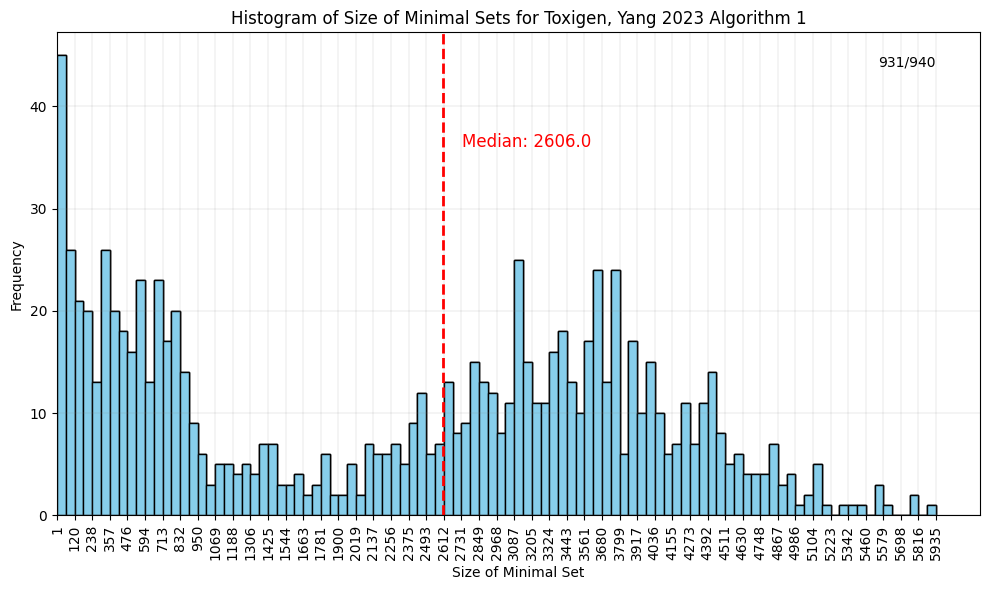

In [4]:
## Visualize Yang 2023 Algorithm1 
import pickle

with open (f"yang2023_alg1_toxigen500.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 1",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

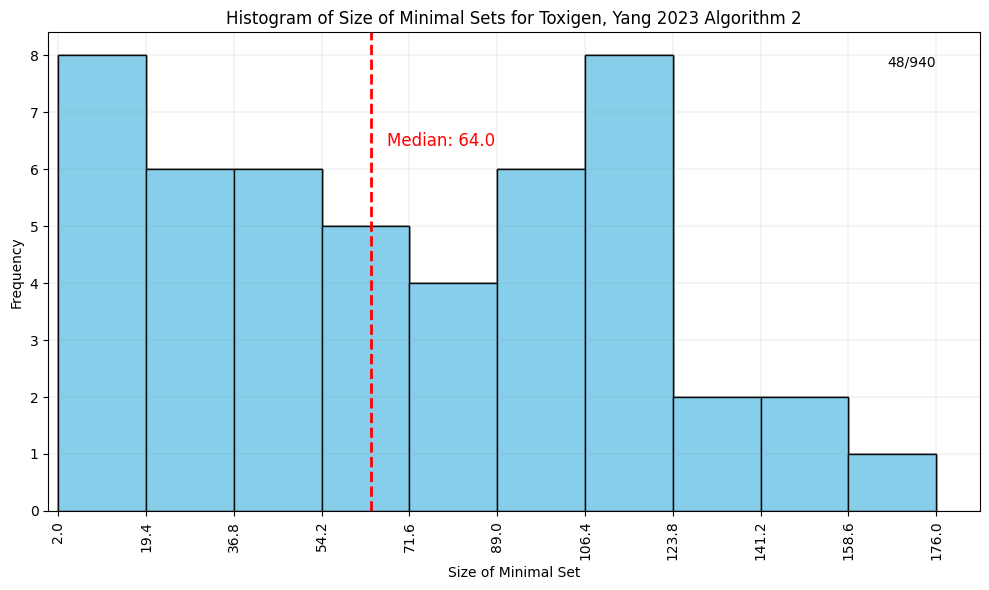

In [5]:
import pickle

# from utils.constants import RESULTS_DIR

# output_dir = RESULTS_DIR / "MinimalSubset"

with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None or len(l) == 0:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 2",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

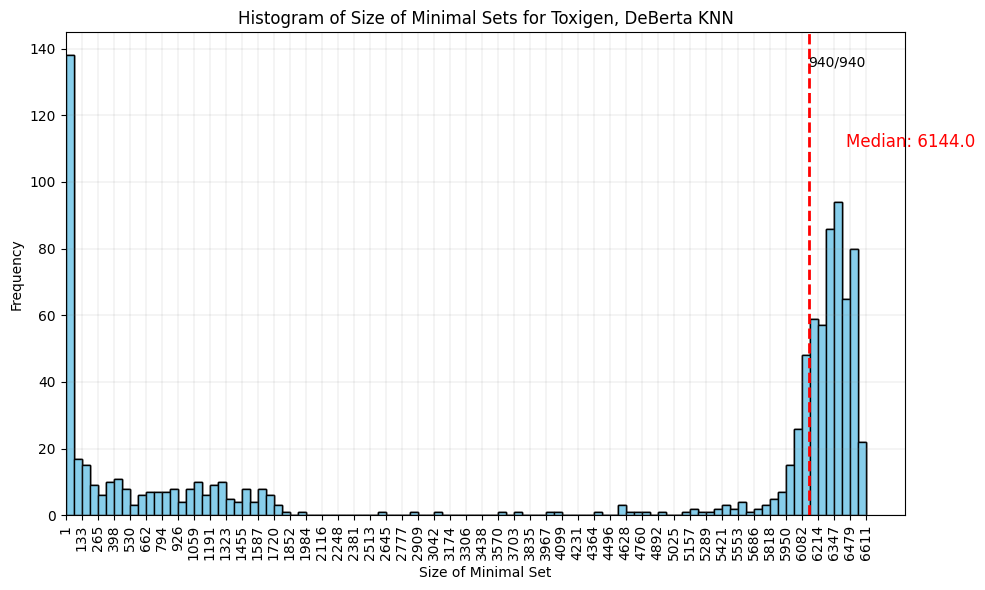

In [6]:
## Visualize KNN
from utils.io import load_json

data = load_json("toxigen_deberta_large_KNN_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta KNN",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.1.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 48/48 [00:01<00:00, 37.08it/s]


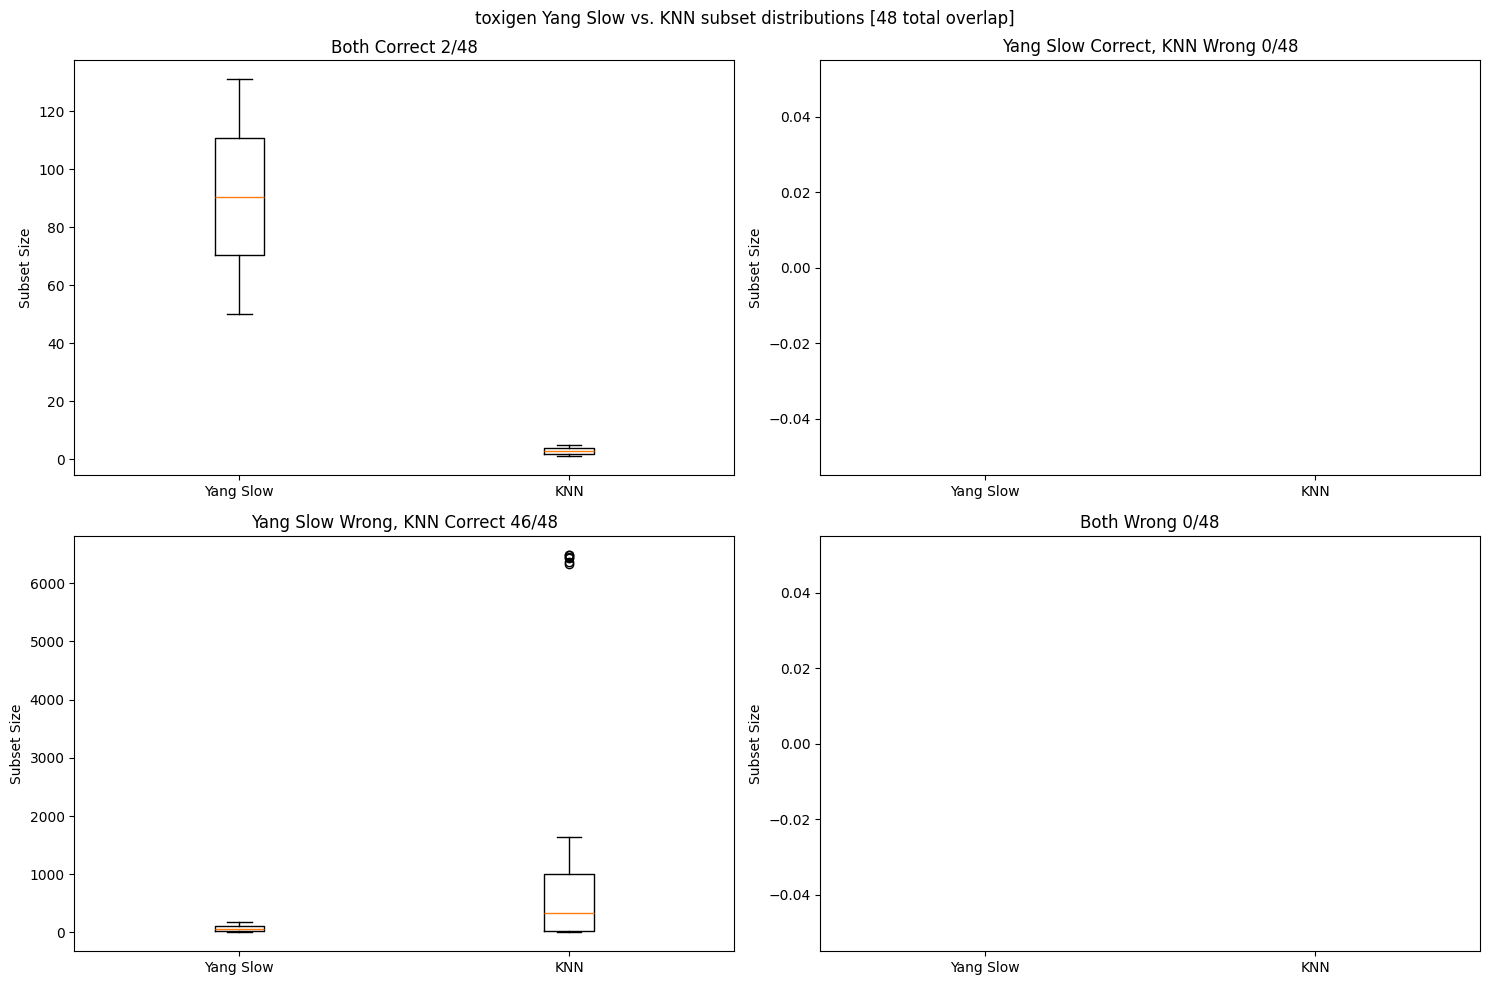

In [40]:
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from utils.io import load_json
import pickle
import matplotlib.pyplot as plt

## Visualize KNN, part 2
wrapper_name = "KNN"

# 1. Load the flip lists and compute subset sizes
with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    yang_flip_list = pickle.load(handle)
yang_subset_sizes = compute_subset_sizes(
    flip_list=yang_flip_list
)

wrapper_flip_list = load_json(f"toxigen_deberta_large_{wrapper_name}_minimal_subsets.json")
wrapper_flip_list = [d['minimum_subset'] for d in wrapper_flip_list]
wrapper_subset_sizes = compute_subset_sizes(
    flip_list=wrapper_flip_list
)

# 2. Find the indices of test examples where both algorithms has identified 
# a (to be verified) subset for
ex_indices_where_both_flip = find_overlapping_example_indices(
    flip_list1=yang_flip_list,
    flip_list2=wrapper_flip_list
)

# 3. Filter subset sizes to only include overlapping examples
yang_subset_sizes = yang_subset_sizes[ex_indices_where_both_flip]
wrapper_subset_sizes = wrapper_subset_sizes[ex_indices_where_both_flip]

# 4. For each of these test ex, verify if Yang's and Ours is correct

# 4a. Fit classifier for both
# TODO: do this aprior and read from disk like KNN
l2 = 500
logit_clf = LogisticRegression(penalty="l2", C= 1 / l2)
logit_clf.fit(train_eval_embeddings, train_eval_labels)

wrapper_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox=wrapper_name
)

# 4b. verify
is_yang_valid = evaluate_predictions(
    clf=logit_clf,
    flip_list=yang_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

is_wrapper_valid = evaluate_predictions(
    clf=wrapper_clf,
    flip_list=wrapper_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

segregate_and_plot(
    dataset_name=DATASET_NAME,
    algorithm1_name="Yang Slow",
    algorithm2_name=wrapper_name,
    is_subsets_correct1=is_yang_valid, 
    is_subsets_correct2=is_wrapper_valid, 
    subset_sizes1=yang_subset_sizes, 
    subset_sizes2=wrapper_subset_sizes,
    ex_indices_where_both_flip=ex_indices_where_both_flip
)

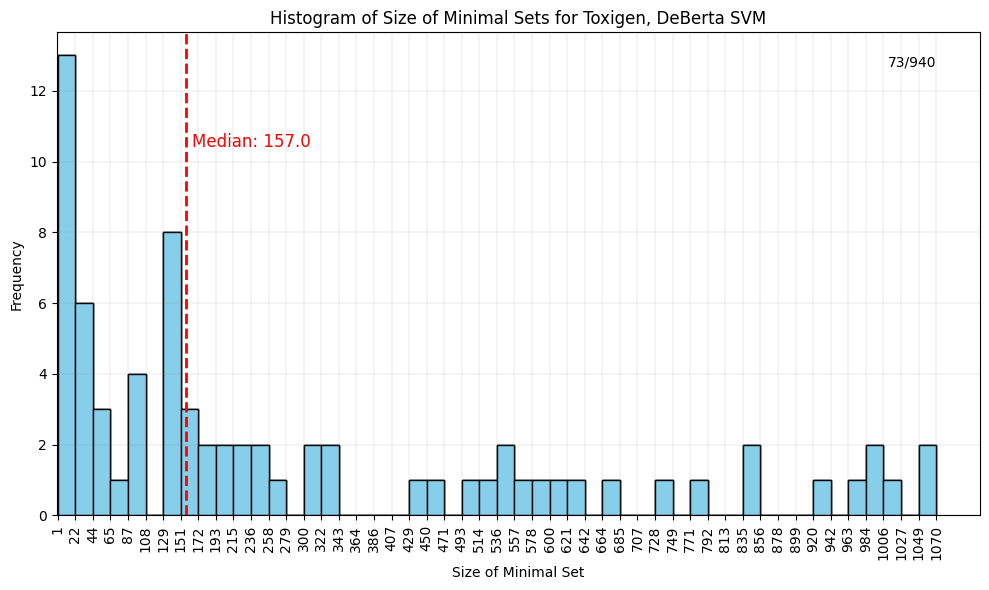

In [66]:
## Visualize SVM
from utils.io import load_json

data = load_json("toxigen_deberta_large_SVM_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta SVM",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.1.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 11/11 [00:47<00:00,  4.32s/it]


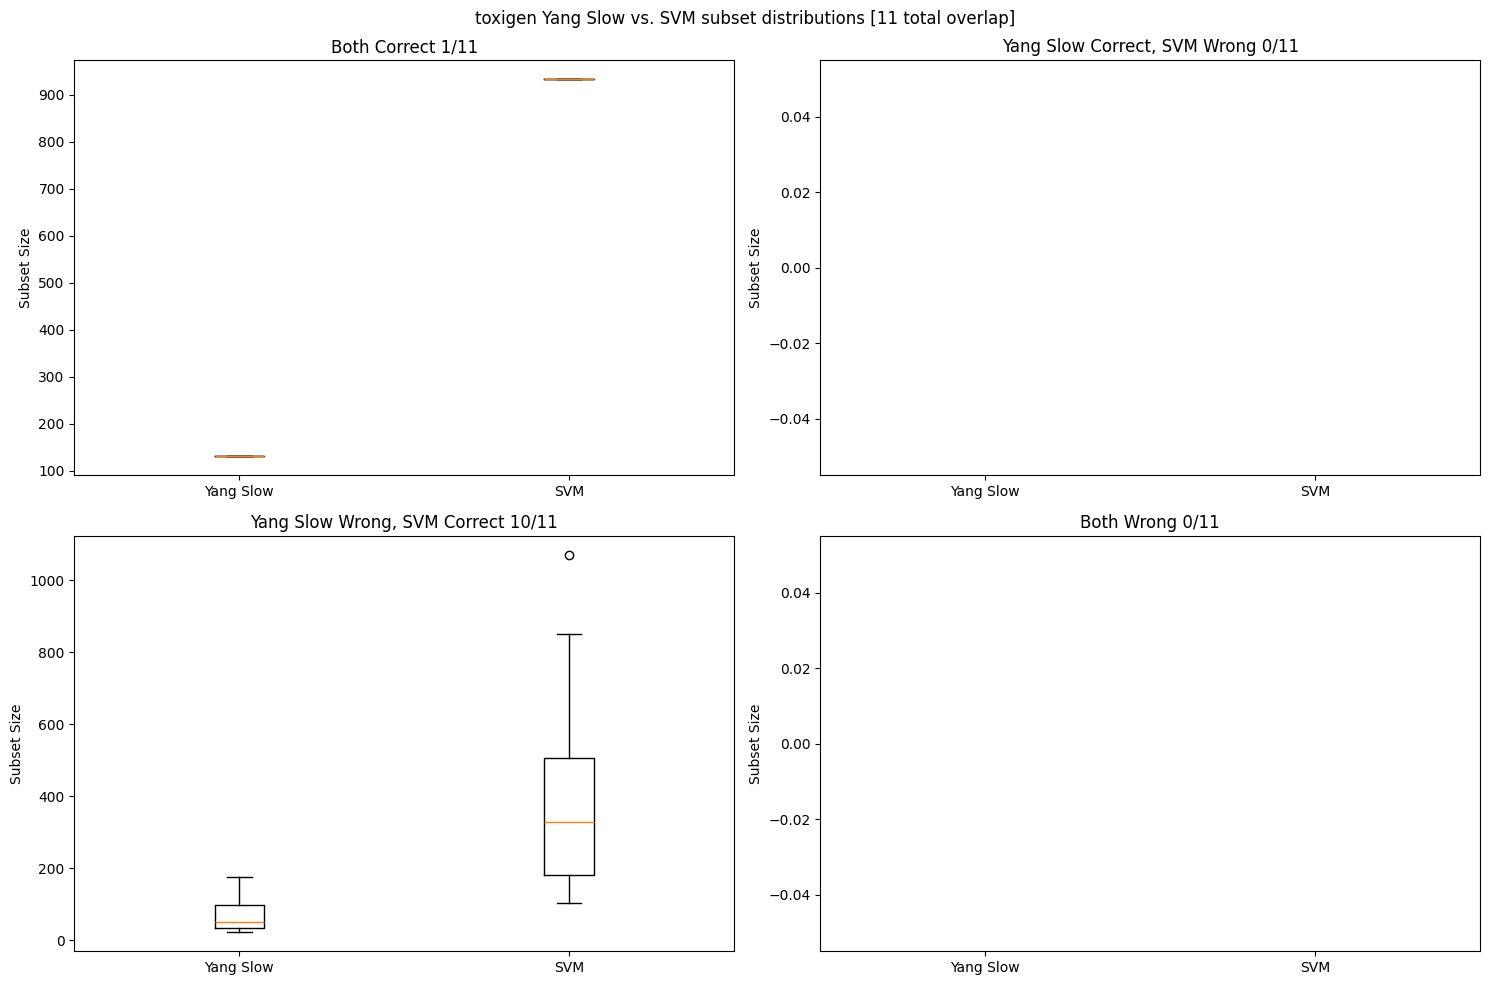

In [55]:
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from utils.io import load_json
import pickle
import matplotlib.pyplot as plt

## Visualize SVM, part 2
wrapper_name = "SVM"

# 1. Load the flip lists and compute subset sizes
with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    yang_flip_list = pickle.load(handle)
yang_subset_sizes = compute_subset_sizes(
    flip_list=yang_flip_list
)

wrapper_flip_list = load_json(f"toxigen_deberta_large_{wrapper_name}_minimal_subsets.json")
wrapper_flip_list = [d['minimum_subset'] for d in wrapper_flip_list]
wrapper_subset_sizes = compute_subset_sizes(
    flip_list=wrapper_flip_list
)

# 2. Find the indices of test examples where both algorithms has identified 
# a (to be verified) subset for
ex_indices_where_both_flip = find_overlapping_example_indices(
    flip_list1=yang_flip_list,
    flip_list2=wrapper_flip_list
)

# 3. Filter subset sizes to only include overlapping examples
yang_subset_sizes = yang_subset_sizes[ex_indices_where_both_flip]
wrapper_subset_sizes = wrapper_subset_sizes[ex_indices_where_both_flip]

# 4. For each of these test ex, verify if Yang's and Ours is correct

# 4a. Fit classifier for both
# TODO: do this aprior and read from disk like KNN
l2 = 500
logit_clf = LogisticRegression(penalty="l2", C= 1 / l2)
logit_clf.fit(train_eval_embeddings, train_eval_labels)

wrapper_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox=wrapper_name
)

# 4b. verify
is_yang_valid = evaluate_predictions(
    clf=logit_clf,
    flip_list=yang_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

is_wrapper_valid = evaluate_predictions(
    clf=wrapper_clf,
    flip_list=wrapper_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

segregate_and_plot(
    dataset_name=DATASET_NAME,
    algorithm1_name="Yang Slow",
    algorithm2_name=wrapper_name,
    is_subsets_correct1=is_yang_valid, 
    is_subsets_correct2=is_wrapper_valid, 
    subset_sizes1=yang_subset_sizes, 
    subset_sizes2=wrapper_subset_sizes,
    ex_indices_where_both_flip=ex_indices_where_both_flip
)

In [39]:
wrapper_flip_list = load_json(f"toxigen_deberta_large_{wrapper_name}_minimal_subsets.json")
wrapper_flip_list = [d['minimum_subset'] for d in wrapper_flip_list]
wrapper_flip_list

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [{'index': 7292, 'example': "because they're lazy!", 'label': 0},
  {'index': 3668,
   'example': 'what a bad person you are! you must have done something to deserve this',
   'label': 0},
  {'index': 8563,
   'example': 'you dont want to ruin your own reputation to support hers',
   'label': 0},
  {'index': 5288, 'example': 'obama is not american', 'label': 0},
  {'index': 501,
   'example': 'if you were born in the usa, you should speak english "   ',
   'label': 1},
  {'index': 7699,
   'example': 'i dont want my kids to become disabled',
   'label': 0},
  {'index': 8659, 'example': 'mother f-er called me a moron', 'label': 1},
  {'index': 8137,
   'example': 'why are you always spreading rumor? he is the victim here! are you a muslim sympathizer?',
   'label': 0},
  {'index': 5052, 'example': 'women like to nag a lot', 'label': 0},
  {'index': 8008,
   'example': "if i were in a wheelchair i'd be so de

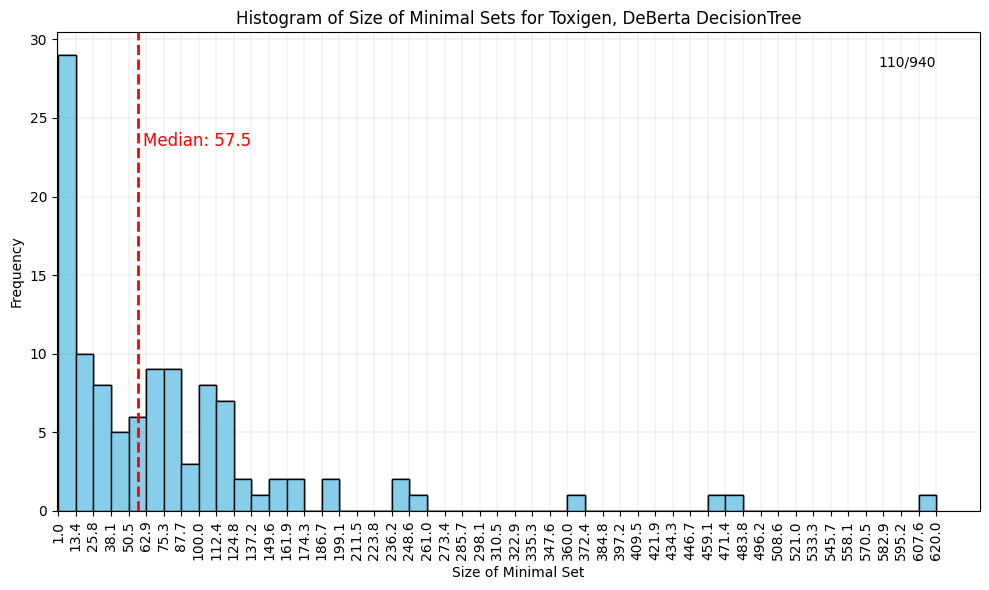

In [6]:
## Visualize DT
from utils.io import load_json

data = load_json("toxigen_deberta_large_DecisionTree_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta DecisionTree",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

100%|██████████| 17/17 [00:50<00:00,  2.98s/it]


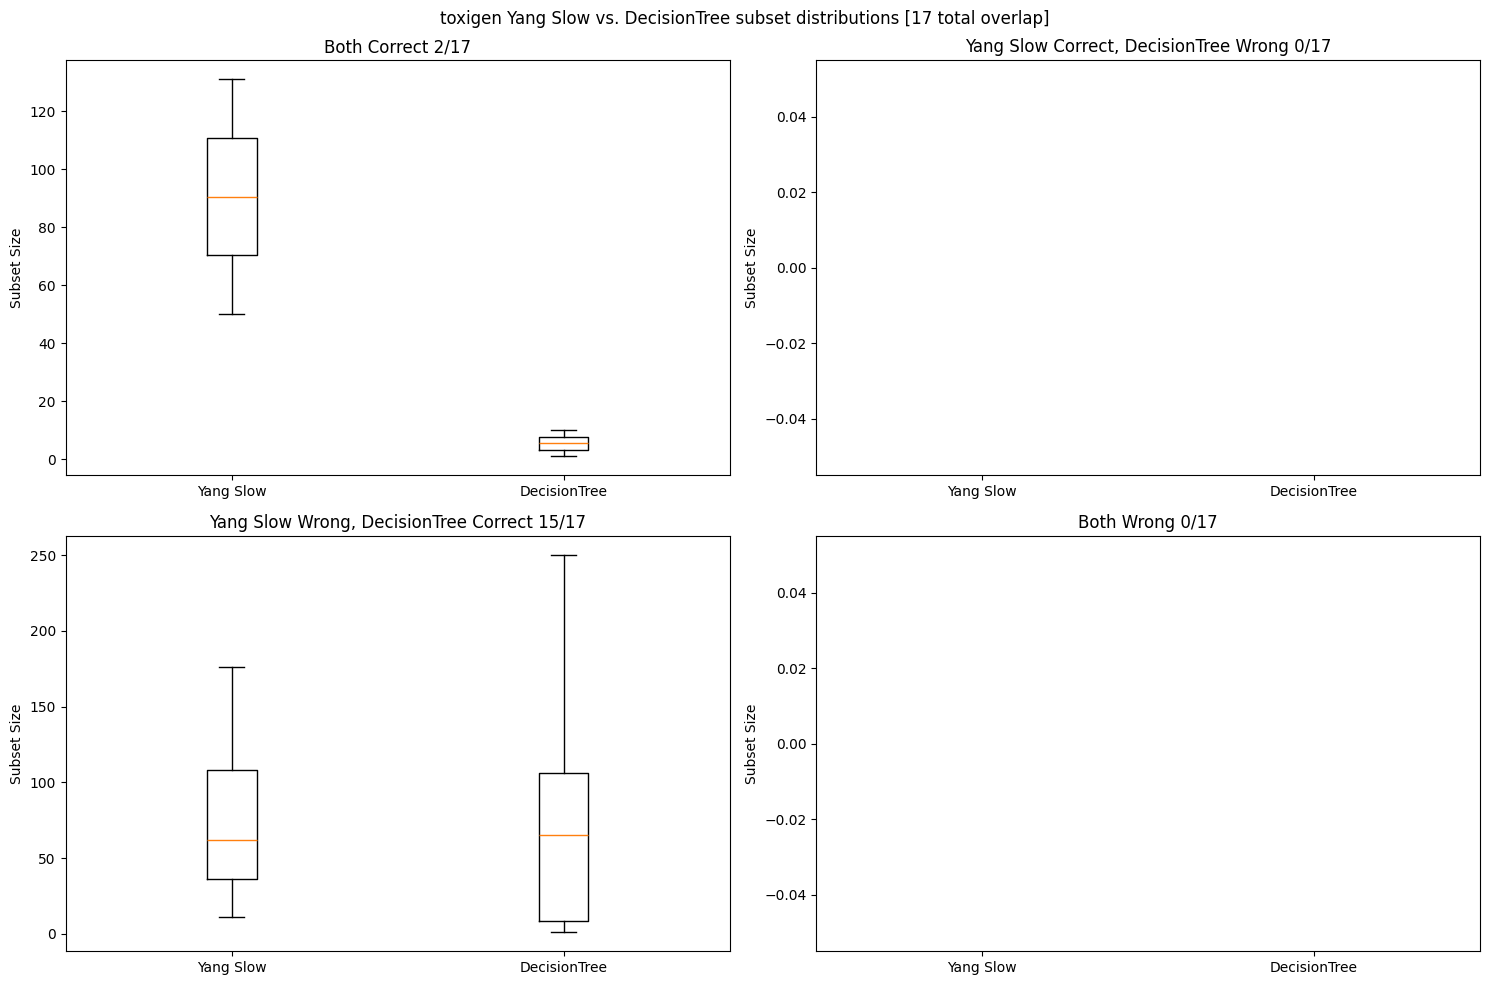

In [56]:
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from utils.io import load_json
import pickle
import matplotlib.pyplot as plt

## Visualize SVM, part 2
wrapper_name = "DecisionTree"

# 1. Load the flip lists and compute subset sizes
with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    yang_flip_list = pickle.load(handle)
yang_subset_sizes = compute_subset_sizes(
    flip_list=yang_flip_list
)

wrapper_flip_list = load_json(f"toxigen_deberta_large_{wrapper_name}_minimal_subsets.json")
wrapper_flip_list = [d['minimum_subset'] for d in wrapper_flip_list]
wrapper_subset_sizes = compute_subset_sizes(
    flip_list=wrapper_flip_list
)

# 2. Find the indices of test examples where both algorithms has identified 
# a (to be verified) subset for
ex_indices_where_both_flip = find_overlapping_example_indices(
    flip_list1=yang_flip_list,
    flip_list2=wrapper_flip_list
)

# 3. Filter subset sizes to only include overlapping examples
yang_subset_sizes = yang_subset_sizes[ex_indices_where_both_flip]
wrapper_subset_sizes = wrapper_subset_sizes[ex_indices_where_both_flip]

# 4. For each of these test ex, verify if Yang's and Ours is correct

# 4a. Fit classifier for both
# TODO: do this aprior and read from disk like KNN
l2 = 500
logit_clf = LogisticRegression(penalty="l2", C= 1 / l2)
logit_clf.fit(train_eval_embeddings, train_eval_labels)

wrapper_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox=wrapper_name
)

# 4b. verify
is_yang_valid = evaluate_predictions(
    clf=logit_clf,
    flip_list=yang_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

is_wrapper_valid = evaluate_predictions(
    clf=wrapper_clf,
    flip_list=wrapper_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

segregate_and_plot(
    dataset_name=DATASET_NAME,
    algorithm1_name="Yang Slow",
    algorithm2_name=wrapper_name,
    is_subsets_correct1=is_yang_valid, 
    is_subsets_correct2=is_wrapper_valid, 
    subset_sizes1=yang_subset_sizes, 
    subset_sizes2=wrapper_subset_sizes,
    ex_indices_where_both_flip=ex_indices_where_both_flip
)

Unique values: [1957, 2008, 2054, 2057, 2064, 2078, 2083, 2120, 2143, 2144, 2163, 2184, 2191, 6414]
Counts: [  1  63   2   1   1   1   1   5   1   1   2   2 196 663]
+--------------------------------------+----------+
|   LMeans Unique Minimal Subset Sizes |   Counts |
|--------------------------------------+----------|
|                                 1957 |        1 |
|                                 2008 |       63 |
|                                 2054 |        2 |
|                                 2057 |        1 |
|                                 2064 |        1 |
|                                 2078 |        1 |
|                                 2083 |        1 |
|                                 2120 |        5 |
|                                 2143 |        1 |
|                                 2144 |        1 |
|                                 2163 |        2 |
|                                 2184 |        2 |
|                                 2191 |      196 |
| 

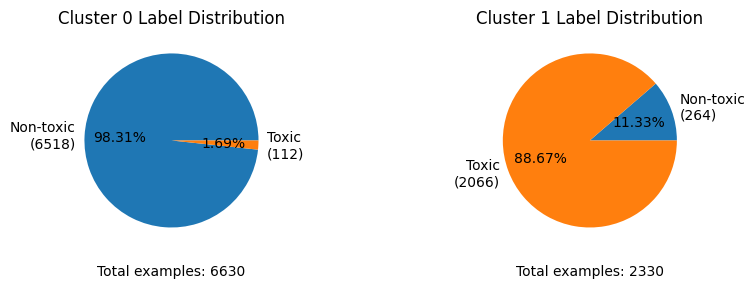

In [138]:
## Visualize LMeans
from tabulate import tabulate
from utils.io import load_json
from typing import Counter
import numpy as np
import pandas as pd

data = load_json("toxigen_deberta_large_LMeans_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

# LMeans is a bit special: looks like we only have ~15 unique 
# subset values, so instead show frequency of thse values
unique_values, counts = np.unique(num_examples, return_counts=True)
print("Unique values:", unique_values.tolist())
print("Counts:", counts)

df = pd.DataFrame({'LMeans Unique Minimal Subset Sizes': unique_values, 'Counts': counts})

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

# Show Cluster Distribution
from utils.partition import get_partition_X
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, lmeans_clf.kmeans_.n_clusters, figsize=(9, 3))
n_clusters = lmeans_clf.kmeans_.n_clusters
for cluster_id, ax in zip(range(n_clusters), axs):
    _, train_indices = get_partition_X(lmeans_clf.kmeans_.labels_, cluster_id)
    cluster_labels = train_eval_labels[train_indices]
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    
    # For plotting cluster distribution
    percents = [counts / np.sum(label_counts) for counts in label_counts ]
    labels = [
        f'{label.capitalize()}\n({count})'
        for label, p, count in zip(LABEL_SPACE, percents, label_counts)
    ]
    ax.pie(label_counts, labels = labels, autopct='%1.2f%%')
    ax.set_title(f'Cluster {cluster_id} Label Distribution')
    ax.text(
        0.5, -0.1, f'Total examples: {np.sum(label_counts)}', 
        horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes
    )
plt.tight_layout()
plt.show()

100%|██████████| 48/48 [00:08<00:00,  5.92it/s]


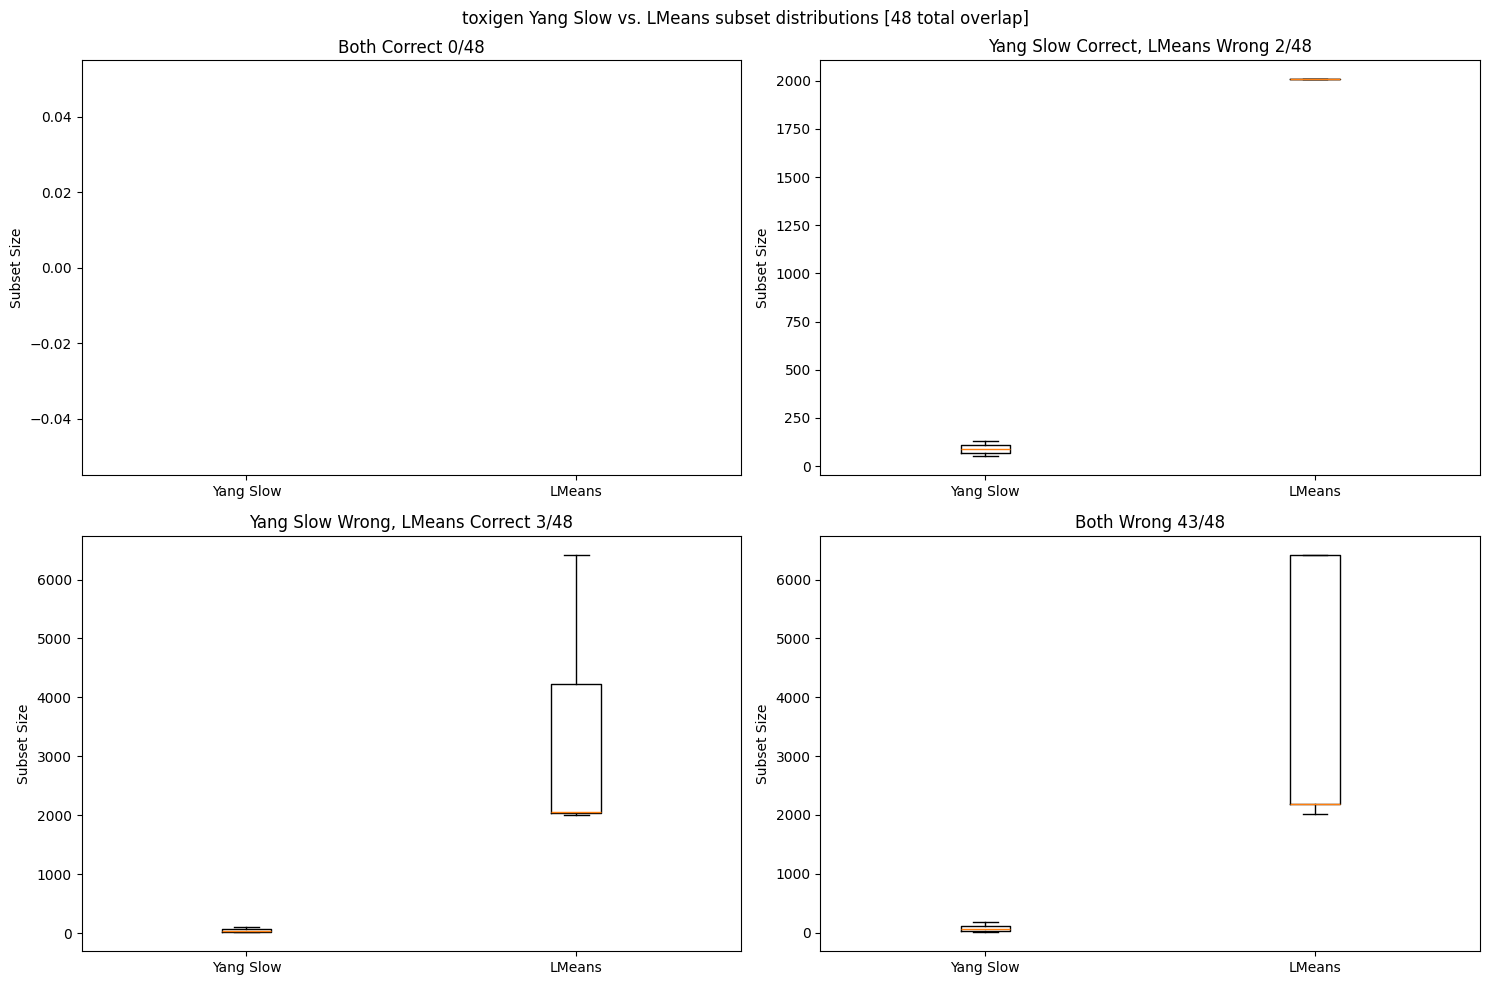

In [57]:
from sklearn import clone
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from utils.io import load_json
import pickle
import matplotlib.pyplot as plt

## Visualize SVM, part 2
wrapper_name = "LMeans"

# 1. Load the flip lists and compute subset sizes
with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    yang_flip_list = pickle.load(handle)
yang_subset_sizes = compute_subset_sizes(
    flip_list=yang_flip_list
)

wrapper_flip_list = load_json(f"toxigen_deberta_large_{wrapper_name}_minimal_subsets.json")
wrapper_flip_list = [d['minimum_subset'] for d in wrapper_flip_list]
wrapper_subset_sizes = compute_subset_sizes(
    flip_list=wrapper_flip_list
)

# 2. Find the indices of test examples where both algorithms has identified 
# a (to be verified) subset for
ex_indices_where_both_flip = find_overlapping_example_indices(
    flip_list1=yang_flip_list,
    flip_list2=wrapper_flip_list
)

# 3. Filter subset sizes to only include overlapping examples
yang_subset_sizes = yang_subset_sizes[ex_indices_where_both_flip]
wrapper_subset_sizes = wrapper_subset_sizes[ex_indices_where_both_flip]

# 4. For each of these test ex, verify if Yang's and Ours is correct

# 4a. Fit classifier for both
# TODO: do this aprior and read from disk like KNN
l2 = 500
logit_clf = LogisticRegression(penalty="l2", C= 1 / l2)
logit_clf.fit(train_eval_embeddings, train_eval_labels)

wrapper_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox=wrapper_name
)

# 4b. verify
is_yang_valid = evaluate_predictions(
    clf=logit_clf,
    flip_list=yang_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

is_wrapper_valid = evaluate_predictions(
    clf=wrapper_clf,
    flip_list=wrapper_flip_list,
    train_embeddings=train_eval_embeddings,
    train_labels=train_eval_labels,
    test_embeddings=test_embeddings,
    ex_indices_where_both_flip=ex_indices_where_both_flip,
)

segregate_and_plot(
    dataset_name=DATASET_NAME,
    algorithm1_name="Yang Slow",
    algorithm2_name=wrapper_name,
    is_subsets_correct1=is_yang_valid, 
    is_subsets_correct2=is_wrapper_valid, 
    subset_sizes1=yang_subset_sizes, 
    subset_sizes2=wrapper_subset_sizes,
    ex_indices_where_both_flip=ex_indices_where_both_flip
)